### Import libraries

In [2]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_bmimAc_PR import configuration

### Create model

In [3]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

2021-04-27 15:34:07 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [4]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [6]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "bmimAc"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [7]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

### Get flash data

In [8]:
# Set pressures to loop over
P = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000]

# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.01,0.15,0.2,0.3,0.4,0.5,0.72,0.91,0.99]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "bmimAc"].fix(0.15)   

        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL) 
        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimAc"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "bmimAc"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
Infeasible.
Running pressure: 200000 and HFC feed fraction 0.15
Running pressure: 200000 and HFC feed fraction 0.2
Running pressure: 200000 and HFC feed fraction 0.3
Running pressure: 200000 and HFC feed fraction 0.4
Running pressure: 200000 and HFC feed fraction 0.5
Running pressure: 200000 and HFC feed fraction 0.72
Running pressure: 200000 and HFC feed fraction 0.91
Running pressure: 200000 and HFC feed fraction 0.99
Running pressure: 300000 and HFC feed fraction 0.001
Running pressure: 300000 and HFC feed fraction 0.15
Running pressure: 300000 and HFC feed fraction 0.2
Running pressure: 300000 and HFC feed fraction 0.3
Running pressure: 300000 and HFC feed fraction 0.4
Running pressure: 300000 and HFC feed fraction 0.5
Running pressure: 300000 and HFC feed fraction 0.72
Running pressure: 300000 and HFC feed fraction 0.91

In [9]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [[ 0.         77.04686762 77.53205516 78.50974824 79.4975914  80.49606335
  82.7325359  84.71147785 85.55880049]
 [66.86500247 68.66489194 69.27505395 70.50548263 71.75028484 73.0105558
  75.84314334 78.36359859 79.44755735]
 [59.61625454 61.67348953 62.36972098 63.77243932 65.19036174 66.62532586
  69.85141952 72.72689714 73.96594792]
 [53.4914492  55.74208988 56.50105923 58.02672944 59.56497666 61.11846215
  64.60272689 67.70320643 69.03887236]
 [48.2225152  50.63090076 51.43885893 53.05753467 54.68305407 56.31900771
  59.97163031 63.20749771 64.59848513]
 [43.61492294 46.16333583 47.01259675 48.70666972 50.39912728 52.09467016
  55.85660517 59.16685437 60.58446246]
 [39.52397195 42.20694106 43.09383751 44.8538236  46.60126754 48.3422736
  52.17536836 55.5191302  56.94377041]
 [35.83882712 38.66027888 39.58401208 41.40607172 43.20227079 44.98056149
  48.86098538 52.21153062 53.63014965]
 [32.4714071  35.44380497 36.40586836 38.2904223  40.13326219 41.94483801
  45.85872366 49.

##### Store

In [10]:
points_x = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

### Ternary Diagram

points 1 are: [(0.0, 0.0, 0.0), (77.0468676234603, 20.817180849735387, 2.1359515268043254), (77.53205516103579, 19.619480413525025, 2.8484644254391904), (78.50974824104064, 17.21562810729683, 4.274623651662537), (79.497591402164, 14.799743675212149, 5.702664922623866), (80.49606335253398, 12.370909445397995, 7.133027202068018), (82.7325358953544, 6.977341996749374, 10.290122107896222), (84.71147785120105, 2.257603830004504, 13.030918318794447), (85.55880049268636, 0.2515760258054765, 14.189623481508173)]
points 2 are: [(66.86500246537345, 33.11463643130598, 0.02036110332057697), (68.6648919424915, 28.283643246070135, 3.05146481143838), (69.27505394964581, 26.65709413520044, 4.067851915153783), (70.50548262501714, 23.39407817285809, 6.100439202124782), (71.75028484054222, 20.11590606586543, 8.13380909359235), (73.01055579922519, 16.820279056070703, 10.169165144704113), (75.84314334139557, 9.497184433657017, 14.659672224947421), (78.36359859180149, 3.0770004772674575, 18.55940093093105),

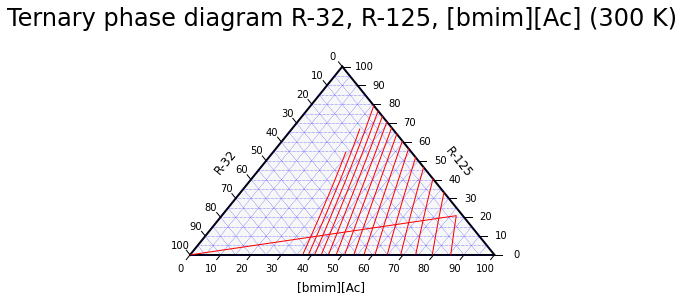

In [11]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [bmim][Ac] (300 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[bmim][Ac]", fontsize=fontsize, offset=offset)

# color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

for i in range(len(P)):
#     color = color_options[i]
    if P[i]<=1400000:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-9:9*i], linewidth=1., color='red', linestyle="-")
    elif P[i]==1500000:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-8:9*i], linewidth=1., color='red', linestyle="-")
    else:
        i = i + 1
        print("points",i,"are:",points_x[9*i-9:9*i])
        tax.plot(points_x[9*i-6:9*i], linewidth=1., color='red', linestyle="-")

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()